In [215]:
import os
import random
import colorsys

import cupy as cp
import pandas as pd
import numpy as np
import cudf
import dask_cudf

from cuml import PCA
from cuml import TSNE
from cuml import KMeans, DBSCAN, AgglomerativeClustering, HDBSCAN
from cuml.metrics.cluster.silhouette_score import cython_silhouette_score
from cuml.preprocessing import StandardScaler, Normalizer
from cuml.pipeline import Pipeline
from sklearn.cluster import KMeans as sklearn_kmeans
from sklearn.cluster import AgglomerativeClustering as sklearn_agg_cluster
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage, dendrogram

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

cp.random.seed(12)
seed = 12
rs = np.random.RandomState(seed)

In [220]:
plt.rcParams["figure.figsize"] = (17, 14)

data_path = "file:///content/drive/My Drive/Rapids/data_mining/data"

# Table of Contents

* Iris Data
  * PCA
  * K-Means
  * HDBSCAN
  * Observations
* Delta Data (Reduced to first 10 principal components)
  * K-Means
  * HDBSCAN
  * Observation
* Movements Data
  * TSNE
  * K-Means
  * DBSCAN & HDBSCAN
  * Agglomerative Clustering
  * Comparing Results
  * Observation

# Important !!!

I will be using the [Rapids](https://rapids.ai/) suite of data science libraries, which can be more scalable compared to pandas and sklearn based workflows. Because these tools are optimized for GPU, this notebook has some hardware requirements.

# Problem 3

## Iris Data

In [227]:
iris = cudf.read_csv(data_path + "/iris.csv")
iris.shape

(150, 6)

In [228]:
iris.head(5)

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


We will perform PCA to see if the data matrix with only the numerical features, which is 4-dimensional, is intrinsically lower-dimensional. Reducing the dimensionality can help with visualizing the results of DBSCAN and K-means. 

Note: Because of PCA, the plots and results of this homework will be different from the class lecture notebook, which uses two features in the original vector space. However, it is just a difference in methodology since combining PCA and clustering is also a valid approach.

### PCA

I determined that the first two principal components of the iris dataset explain over $95\%$ of the variance in the data. Therefore, we will apply K-means and DBSCAN on the two-dimensional data matrix consisting of the first two principal components.

In [229]:
# Select the numerical columns
pca_df = StandardScaler().fit_transform(iris.iloc[:, 1:5])

pca = PCA(n_components=4, whiten=True)

# Fit the PCA instance to the scaled samples
pca.fit(pca_df);

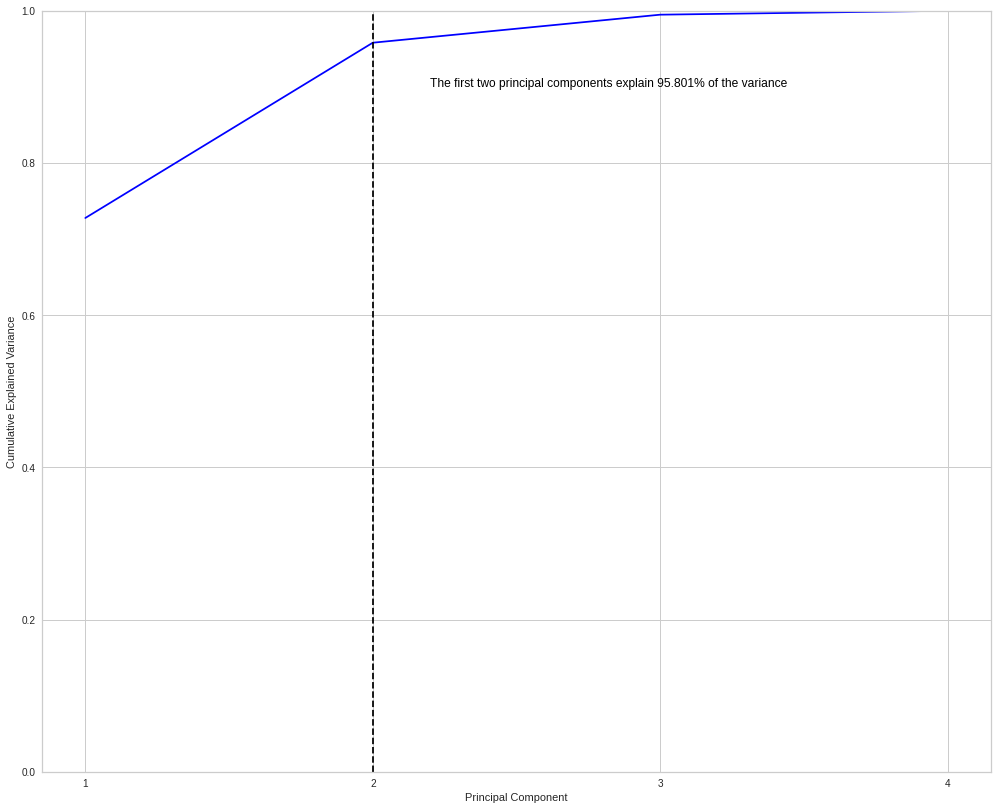

In [230]:
# Cumulative explained variance
cum_exp_var = cp.cumsum(
    pca.explained_variance_ratio_.values
).get()  # Use get to convert to np.ndarray
pc_indices = range(1, pca._n_components + 1)

plt.plot(pc_indices, cum_exp_var, color="blue")
plt.ylim(0, 1)
plt.xticks(pc_indices)
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance")
plt.axvline(x=2, color="black", linestyle="--")
# Add a label at x = 1 for the value of y
plt.text(
    2.2,
    0.9,
    f"The first two principal components explain {round(cum_exp_var[1] * 100, 4)}% of the variance",
    color="black",
)
plt.show();

We can obtain the first two principal components of the iris data set:

In [231]:
pca = PCA(n_components=2, whiten=True)

iris_pcs = pca.fit_transform(pca_df)
iris_pcs.shape

(150, 2)

### K-Means

First, we select the number of clusters using the Calinski Harabasz Score, which is also used in homework 1. I won't rewrite the mathematical formulation again.

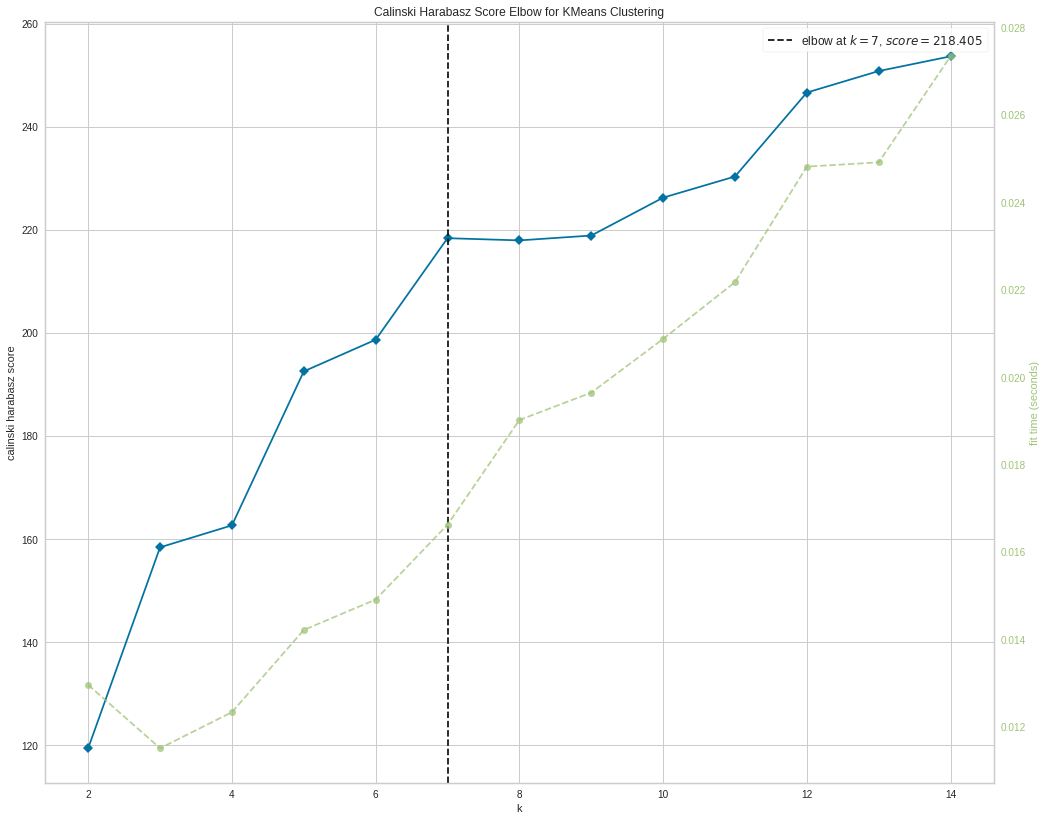

In [232]:
# Define range for number of clusters
k_range = range(2, 15)

model_iris_kmeans = sklearn_kmeans(n_init=10, random_state=rs)

visualizer = KElbowVisualizer(
    estimator=model_iris_kmeans, k=k_range, metric="calinski_harabasz", timings=True
)
visualizer.fit(iris_pcs.to_numpy())
visualizer.show();

It appears that 7 is the number of clusters suggested by the heuristic. We will proceed to apply K-means accordingly.

In [233]:
# Pipeline
pipeline_iris_kmeans = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=2, whiten=True)),
        ("kmeans", KMeans(n_clusters=7, random_state=12, n_init=10)),
    ]
)

# Fit the pipeline to samples and predict the cluster labels
iris_labels_kmeans = pipeline_iris_kmeans.fit_predict(iris.iloc[:, 1:5]).to_numpy()

iris_labels_kmeans

array([6, 1, 1, 1, 6, 2, 6, 6, 1, 1, 2, 6, 1, 1, 2, 2, 2, 6, 2, 2, 6, 2,
       6, 6, 6, 1, 6, 6, 6, 1, 1, 6, 2, 2, 1, 1, 6, 1, 1, 6, 6, 3, 1, 6,
       2, 1, 2, 1, 2, 6, 0, 0, 0, 3, 4, 4, 0, 3, 4, 3, 3, 4, 3, 4, 4, 0,
       4, 4, 3, 3, 0, 4, 4, 4, 4, 0, 4, 0, 4, 3, 3, 3, 4, 4, 4, 0, 0, 3,
       4, 3, 3, 4, 3, 3, 4, 4, 4, 4, 3, 4, 0, 4, 0, 4, 0, 0, 3, 0, 4, 5,
       0, 4, 0, 3, 4, 0, 0, 5, 0, 3, 0, 4, 0, 4, 0, 0, 4, 4, 4, 0, 0, 5,
       4, 4, 4, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 4], dtype=int32)

We can plot the predicted cluster labels using the first two principal components.

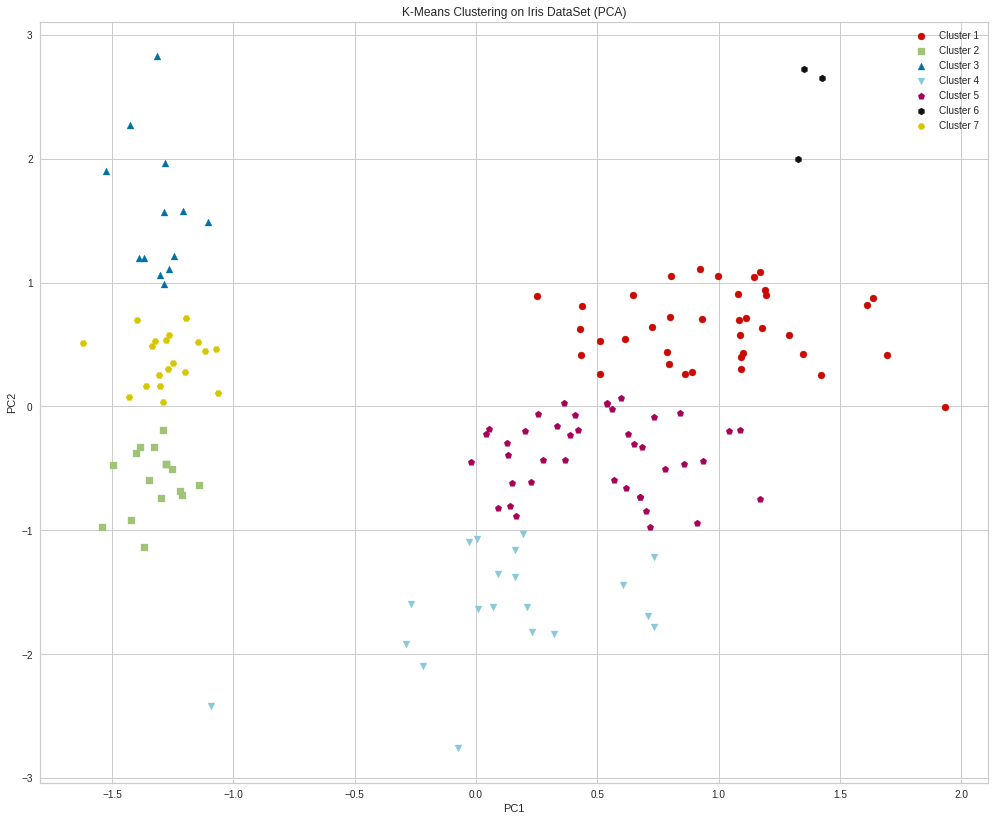

In [239]:
# Data for plotting
x_iris_pca = iris_pcs.iloc[:, 0].to_numpy()
y_iris_pca = iris_pcs.iloc[:, 1].to_numpy()
c_kmeans_iris = iris_labels_kmeans

# Define a color map and markers for each cluster
colors = ["r", "g", "b", "c", "m", "k", "y"]
markers = ["o", "s", "^", "v", "p", "h", "H"]

# Create the scatter plot
fig, ax = plt.subplots()
for c in np.unique(c_kmeans_iris):
    mask = c_kmeans_iris == c
    ax.scatter(x_iris_pca[mask], y_iris_pca[mask], c=colors[c], marker=markers[c])

# Add axis labels and show the plot
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-Means Clustering on Iris DataSet (PCA)")
plt.legend(["Cluster" + f" {i + 1}" for i in range(7)])
plt.show();

### HDBSCAN

We will use `HDBSCAN` to perform DBSCAN over varying epsilon values and integrate the result to find a clustering that gives the best stability over epsilon. This allows us to tune just one of the two hyperparameters of the clustering algorithm, and thus simplifying the tuning task. 

Note: we use the Silhouette score to evaluate the clustering results over a range of values for minimum samples.

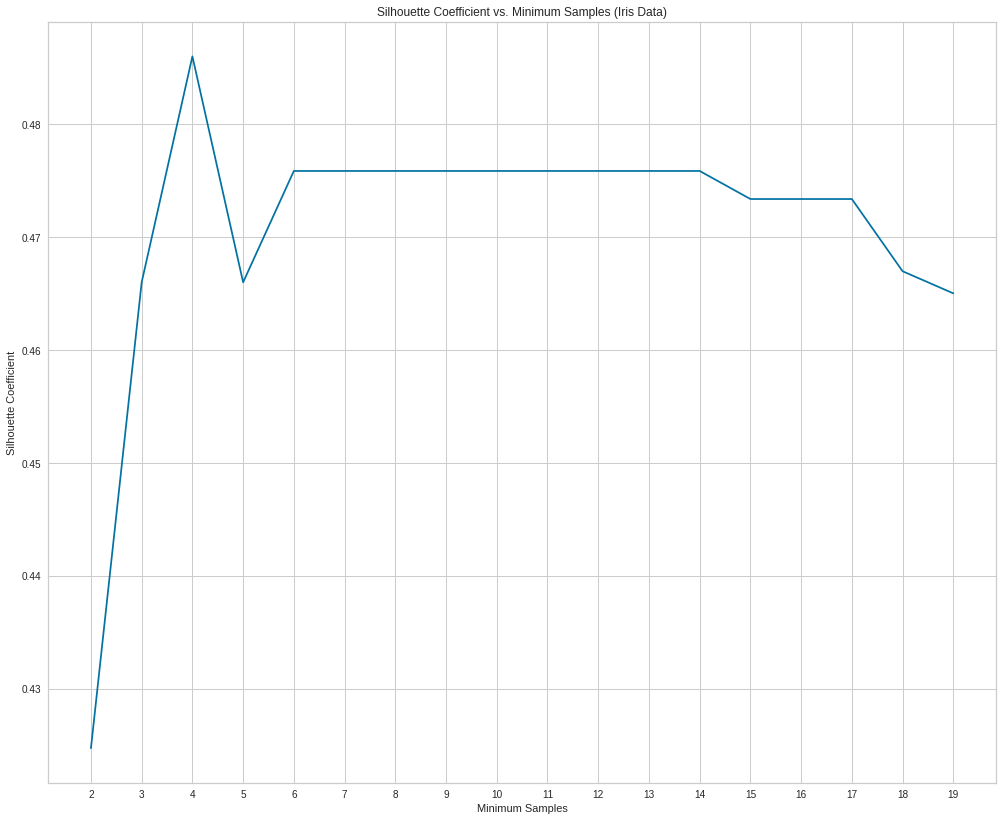

In [235]:
sc_scores = []
min_samples_range = np.arange(2, 20)

for min_samples in min_samples_range:
    hdbscan = HDBSCAN(min_samples=min_samples, metric="euclidean")
    hdbscan.fit(iris_pcs)
    sc_scores.append(cython_silhouette_score(iris_pcs, hdbscan.labels_))

plt.plot(min_samples_range, sc_scores)
plt.xlabel("Minimum Samples")
plt.ylabel("Silhouette Coefficient")
plt.title("Silhouette Coefficient vs. Minimum Samples (Iris Data)")
plt.xticks(min_samples_range)
plt.show();

Based on the plot, the best Silhouette coefficient is achieved at `min_samples=4`.

In [250]:
iris_hdbscan = HDBSCAN(min_samples=4, metric="euclidean")

iris_labels_hdbscan = iris_hdbscan.fit_predict(iris_pcs).to_numpy()

print("HDBSCAN results in", len(np.unique(iris_labels_hdbscan)) - 1, "clusters")

HDBSCAN results in 2 clusters


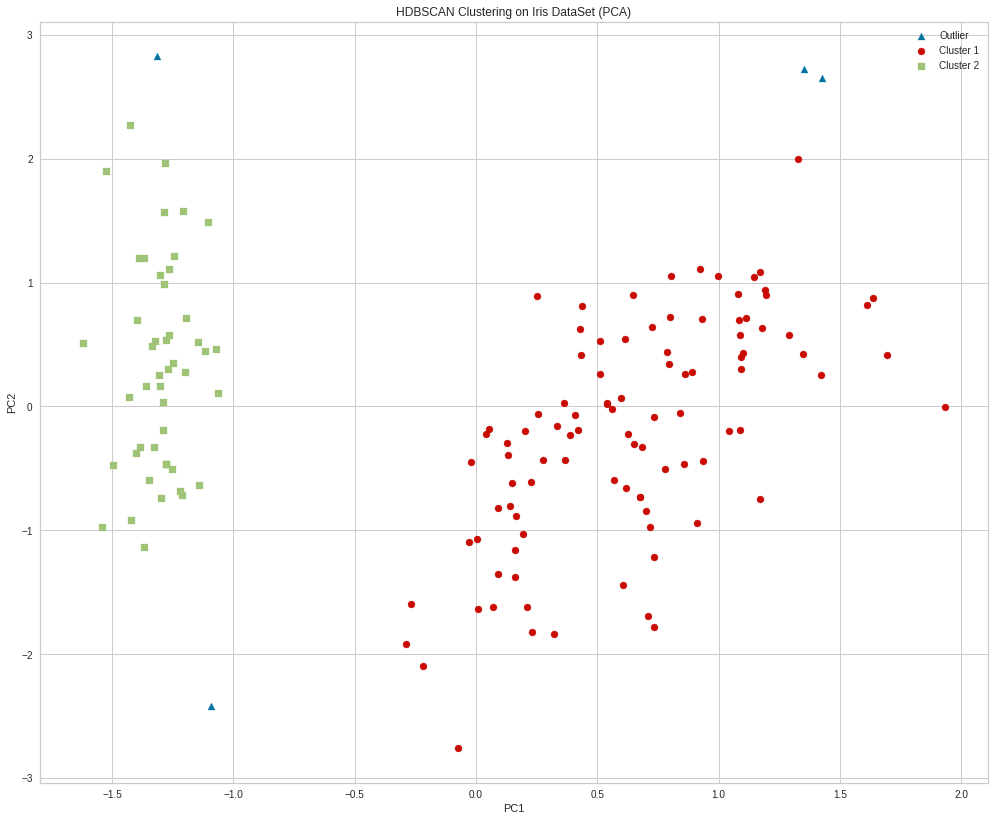

In [241]:
# Data for plotting
c_hdbscan_iris = iris_labels_hdbscan

# Define a color map and markers for each cluster
colors = ["r", "g", "b"]
markers = ["o", "s", "^"]

# Create the scatter plot
fig, ax = plt.subplots()
for c in np.unique(c_hdbscan_iris):
    mask = c_hdbscan_iris == c
    ax.scatter(x_iris_pca[mask], y_iris_pca[mask], c=colors[c], marker=markers[c])

# Add axis labels and show the plot
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("HDBSCAN Clustering on Iris DataSet (PCA)")
plt.legend(["Outlier", "Cluster 1", "Cluster 2"])
plt.show();

### Observation

K-Means is a centroid-based algorithm, which means it finds the center point of each cluster (centroid) and partitions the data points into groups that are closest to those center points. 

HDBSCAN is a density-based algorithm, which means it groups data points that are close together in space and separates clusters based on the **density** of data points. It does not require the user to specify the number of clusters in advance, and it can handle clusters of varying densities and shapes.

Additionally, HDBSCAN uses a hierarchical approach to clustering, which means it can find clusters at different levels of granularity (e.g. subclusters within clusters) and can identify noise and outliers.

On the Iris dataset, K-Means suggested more clusters (7 clusters) than did HDBSCAN (2 clusters plus outlier group). Visual assessment shows that HDBSCAN resulted in more sensible clustering outputs.

## Delta Data 

We will apply the techniques on the first 10 principal components of the aircraft dataset.

In [242]:
delta = np.load(
    "drive/My Drive/Rapids/data_mining/data/delta_reduced.npy", encoding="bytes"
)
delta.shape

(44, 10)

### K-Means

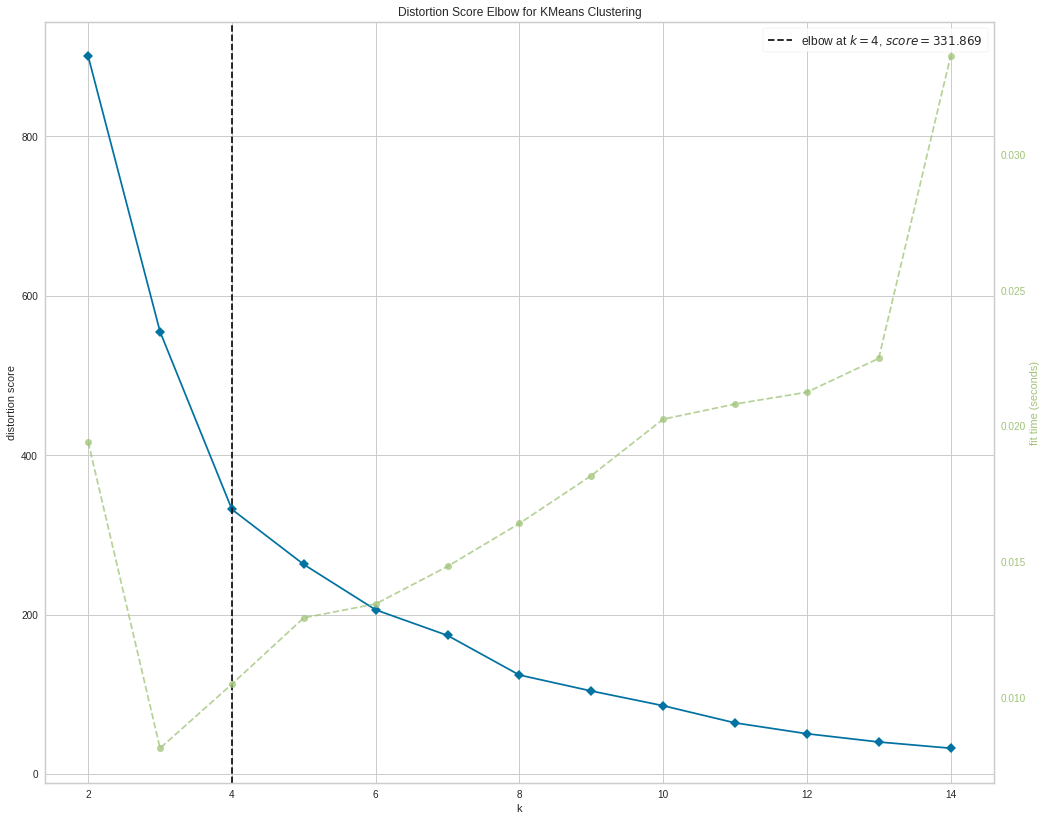

In [243]:
# Define range for number of clusters
k_range = range(2, 15)

model_delta_kmeans = sklearn_kmeans(n_init=10, random_state=rs)

visualizer = KElbowVisualizer(
    estimator=model_delta_kmeans, k=k_range, metric="distortion", timings=True
)
visualizer.fit(delta)
visualizer.show();

Using 'distortion' as the metric, we see that the number of clusters suggested by the heuristic is 4. In fact, using the CH index yields the same result. Note that the data matrix is composed of the first 10 principal components of the original data, and so no preprocessing is needed before applying K-means.

In [244]:
# Fit the pipeline to samples and predict the cluster labels
delta_labels_kmeans = KMeans(
    n_clusters=4, random_state=12, n_init=10, output_type="numpy"
).fit_predict(delta)

delta_labels_kmeans

array([0, 2, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 3, 3, 0, 0, 3, 0, 0, 3, 0, 0, 0],
      dtype=int32)

We will plot the results of K-means using the first two principal components.

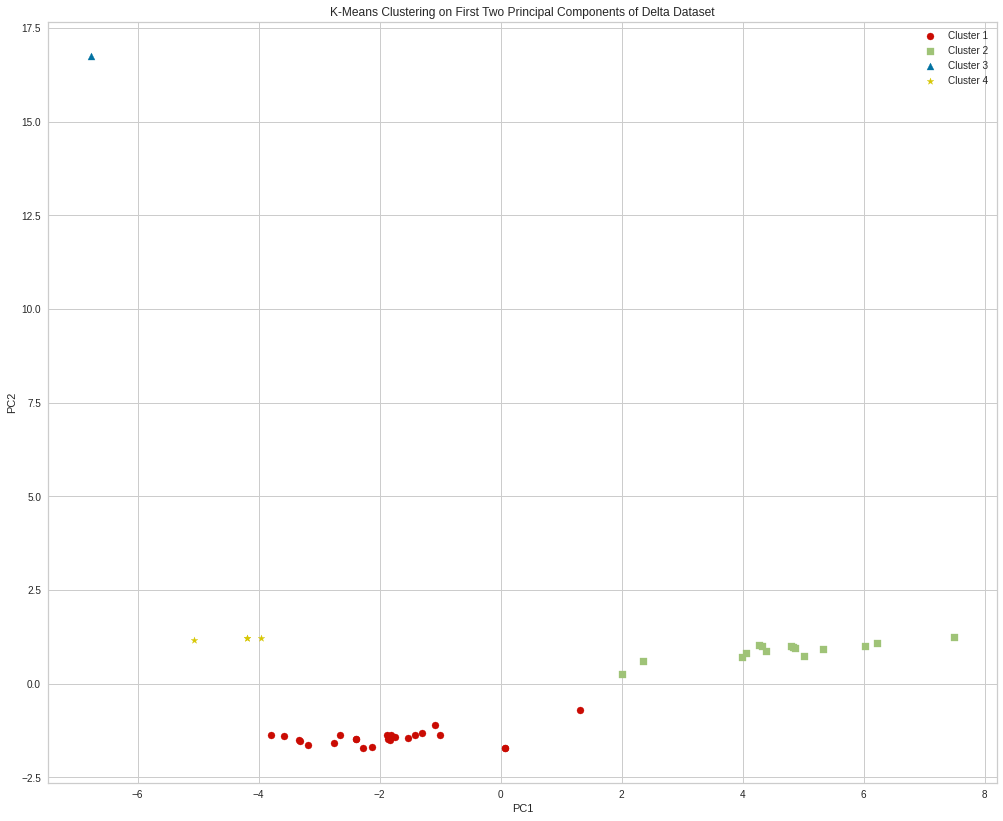

In [245]:
# Data for plotting
x_delta_pca = delta[:, 0]
y_delta_pca = delta[:, 1]
c_kmeans_delta = delta_labels_kmeans

# Define a color map and markers for each cluster
colors = ["r", "g", "b", "y"]
markers = ["o", "s", "^", "*"]

# Create the scatter plot
fig, ax = plt.subplots()
for c in np.unique(c_kmeans_delta):
    mask = c_kmeans_delta == c
    ax.scatter(x_delta_pca[mask], y_delta_pca[mask], c=colors[c], marker=markers[c])

# Add axis labels and show the plot
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-Means Clustering on First Two Principal Components of Delta Dataset")
plt.legend(["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"])

# Show the plot
plt.show();

Alternatively, we can use T-SNE to visualize the K-means clustering results on the two-dimensional x-y plane. Since the `delta` data is already in the principal component space, applying T-SNE to the principal components is similary to using PCA to informatively initialize the T-SNE optimization process.

In [247]:
# Use default
delta_tsne = TSNE(
    n_components=2,
    random_state=12,
    perplexity=5,
    method="fft",
    learning_rate_method="adaptive",
    output_type="numpy",
).fit_transform(delta)

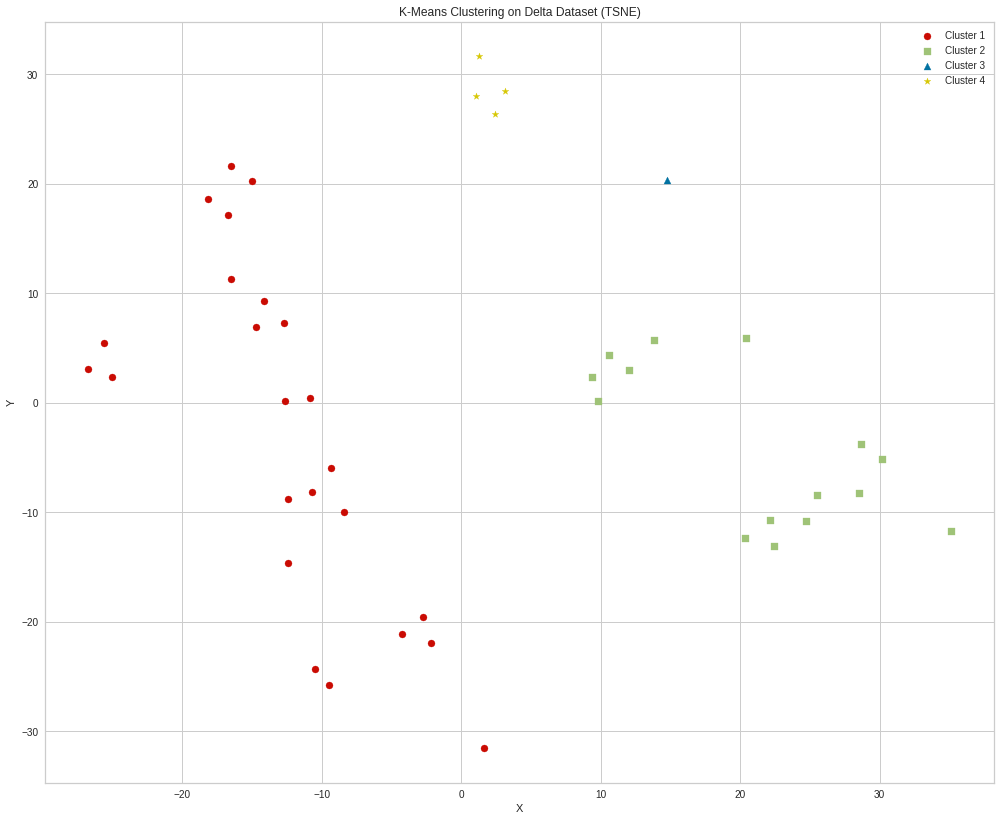

In [248]:
# Data for plotting
x_delta_tsne = delta_tsne[:, 0]
y_delta_tsne = delta_tsne[:, 1]
c_kmeans_delta = delta_labels_kmeans

# Define a color map and markers for each cluster
colors = ["r", "g", "b", "y"]
markers = ["o", "s", "^", "*"]

# Create the scatter plot
fig, ax = plt.subplots()
for c in np.unique(c_kmeans_delta):
    mask = c_kmeans_delta == c
    ax.scatter(x_delta_tsne[mask], y_delta_tsne[mask], c=colors[c], marker=markers[c])

# Add axis labels and show the plot
plt.xlabel("X")
plt.ylabel("Y")
plt.title("K-Means Clustering on Delta Dataset (TSNE)")
plt.legend(["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"])

# Show the plot
plt.show();

As can be seen, the T-SNE visualization with perlexity equaling 5 is visually more appealing than that of the PCA plot. The K-means algorithms appears to have sufficiently partitioned the sample space into four clusters.

### HDBSCAN

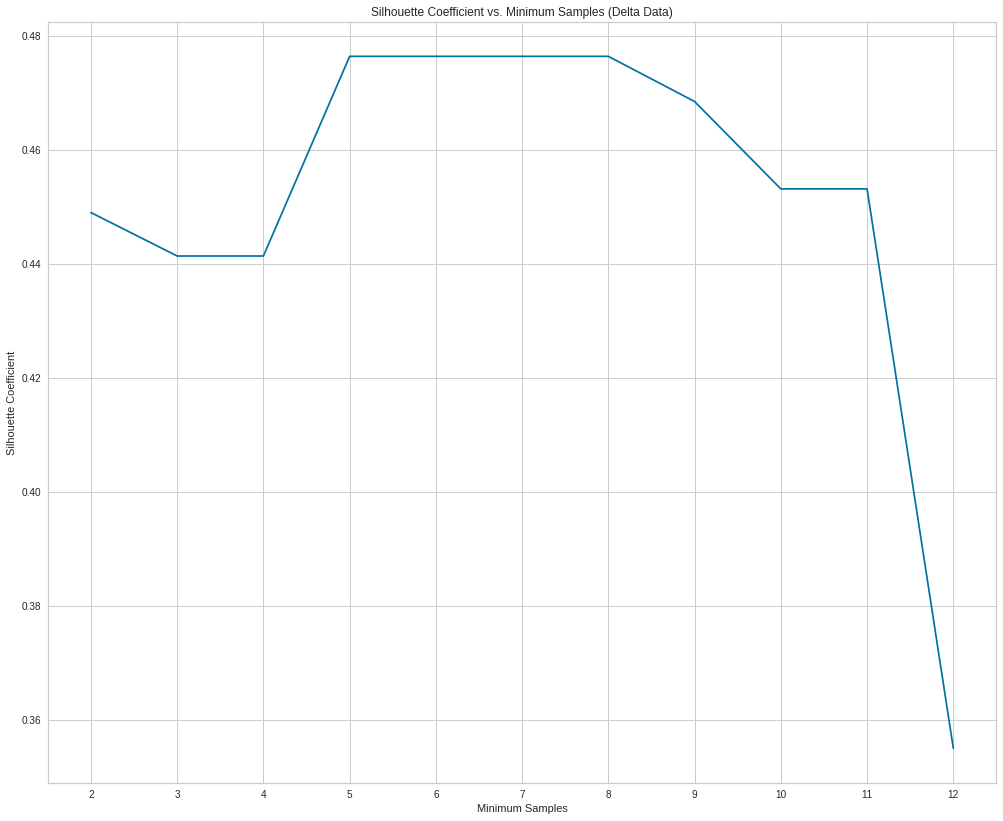

In [249]:
sc_scores = []
min_samples_range = np.arange(2, 13)

for min_samples in min_samples_range:
    hdbscan = HDBSCAN(min_samples=min_samples, metric="euclidean")
    hdbscan.fit(delta)
    sc_scores.append(cython_silhouette_score(delta, hdbscan.labels_))

plt.plot(min_samples_range, sc_scores)
plt.xlabel("Minimum Samples")
plt.ylabel("Silhouette Coefficient")
plt.title("Silhouette Coefficient vs. Minimum Samples (Delta Data)")
plt.xticks(min_samples_range)
plt.show();

Based on the plot, the best Silhouette coefficient is achieved within the range of `min_samples=5` to `min_samples=8`. Again, no preprocessing is needed since we are applying clustering on principal components.

In [251]:
delta_hdbscan = HDBSCAN(min_samples=6, metric="euclidean", output_type="numpy")

delta_labels_hdbscan = delta_hdbscan.fit_predict(delta)

# This result is the same for min_sample = 5, ...., 8
print("HDBSCAN results in", len(np.unique(delta_labels_hdbscan)) - 1, "clusters")

HDBSCAN results in 2 clusters


Visualize HDBSCAN clustering results based on PCA:

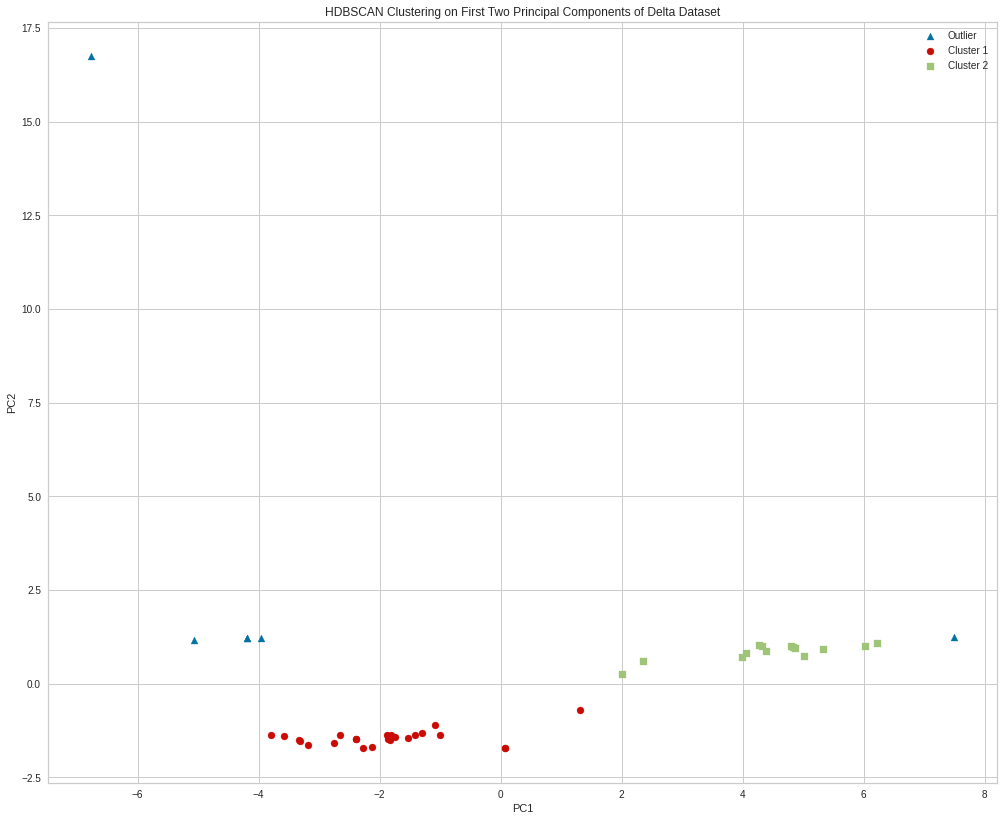

In [254]:
# Data for plotting
c_hdbscan_delta = delta_labels_hdbscan

# Define a color map and markers for each cluster
colors = ["r", "g", "b"]
markers = ["o", "s", "^"]

# Create the scatter plot
fig, ax = plt.subplots()
for c in np.unique(c_hdbscan_delta):
    mask = c_hdbscan_delta == c
    ax.scatter(x_delta_pca[mask], y_delta_pca[mask], c=colors[c], marker=markers[c])

# Add axis labels and show the plot
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("HDBSCAN Clustering on First Two Principal Components of Delta Dataset")
plt.legend(["Outlier", "Cluster 1", "Cluster 2"])
plt.show();

Visualizing using TSNE:

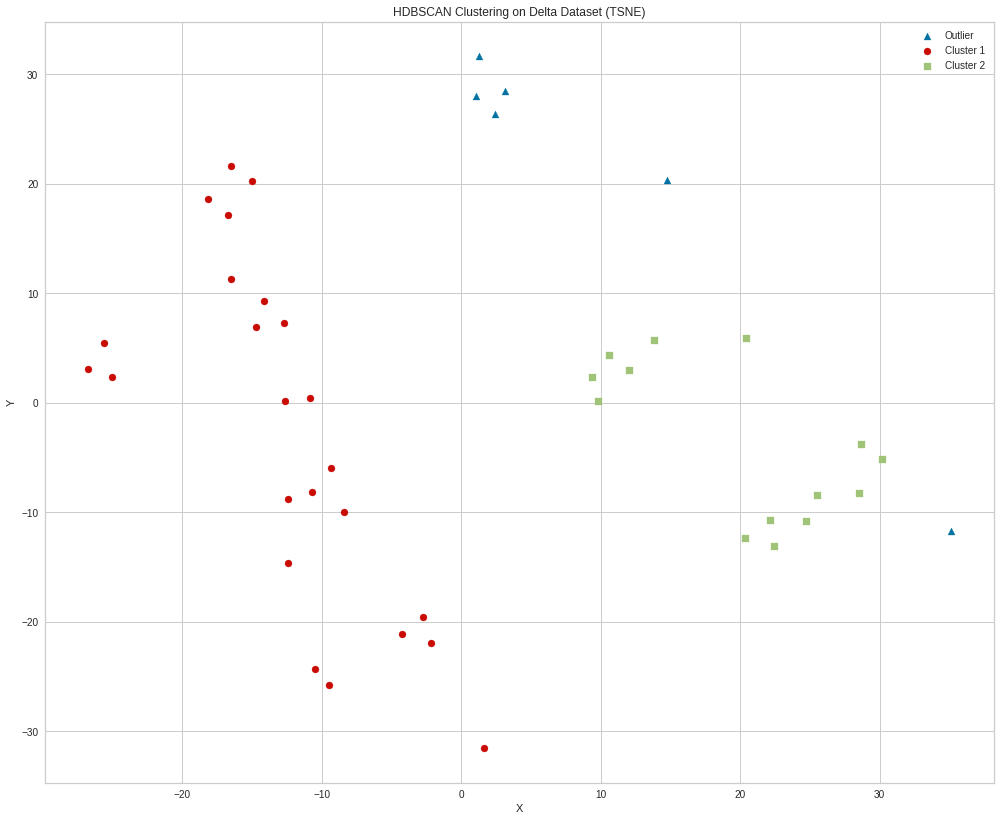

In [255]:
# Create the scatter plot
fig, ax = plt.subplots()
for c in np.unique(c_hdbscan_delta):
    mask = c_hdbscan_delta == c
    ax.scatter(x_delta_tsne[mask], y_delta_tsne[mask], c=colors[c], marker=markers[c])

# Add axis labels and show the plot
plt.xlabel("X")
plt.ylabel("Y")
plt.title("HDBSCAN Clustering on Delta Dataset (TSNE)")
plt.legend(["Outlier", "Cluster 1", "Cluster 2"])
plt.show();

### Observation

For the first 10 principal components of the delta dataset, HDBSCAN and K-means resulted in similar clusters. Interestingly, K-means resulted in one extra cluster, namely, cluster 3, containing only one data point. In HDBSCAN, such a data point, along with a few other points closer to it, is labeled as an outlier (see blue and yellow clusters in the TSNE plots for K-means and HDBSCAN above). 

Another interesting observation is that TSNE, with PCA initialization, is the most suitable visualization technique for this particular use case. This is mainly due to the fact that the first two principal components of the delta dataset do not capture enough co-variation structure of the original data matrix.

## Movements Data

In [52]:
movements = cudf.read_csv(data_path + "/movements.csv", index_col=0)
movements.shape

(60, 963)

In [54]:
movements.head(3)

,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-11,2010-01-12,2010-01-13,2010-01-14,2010-01-15,...,2013-10-16,2013-10-17,2013-10-18,2013-10-21,2013-10-22,2013-10-23,2013-10-24,2013-10-25,2013-10-28,2013-10-29
0,,,,,,,,,,,,,,,,,,,,,
Apple,0.580000,-0.220005,-3.409998,-1.170000,1.680011,-2.689994,-1.469994,2.779997,-0.680003,-4.999995,...,0.320008,4.519997,2.899987,9.590019,-6.540016,5.959976,6.910011,-5.359962,0.840019,-19.589981
AIG,-0.640002,-0.650000,-0.210001,-0.420000,0.710001,-0.200001,-1.130001,0.069999,-0.119999,-0.500000,...,0.919998,0.709999,0.119999,-0.480000,0.010002,-0.279998,-0.190003,-0.040001,-0.400002,0.660000
Amazon,-2.350006,1.260009,-2.350006,-2.009995,2.960006,-2.309997,-1.640007,1.209999,-1.790001,-2.039994,...,2.109985,3.699982,9.570008,-3.450013,4.820008,-4.079986,2.579986,4.790009,-1.760009,3.740021


In [68]:
print("There are", len(movements.index), "unique companies")

There are 60 unique companies


### TSNE

To start with some visualization of the data, we will apply TSNE on the 963-dimensional data.

In [256]:
# Normalize the features to unit norms
movements_normalized = Normalizer().fit_transform(movements)

In [262]:
movements_tsne = TSNE(
    n_components=2,
    random_state=12,
    perplexity=7,
    method="fft",
    learning_rate_method="adaptive",
    output_type="numpy",
).fit_transform(movements_normalized)

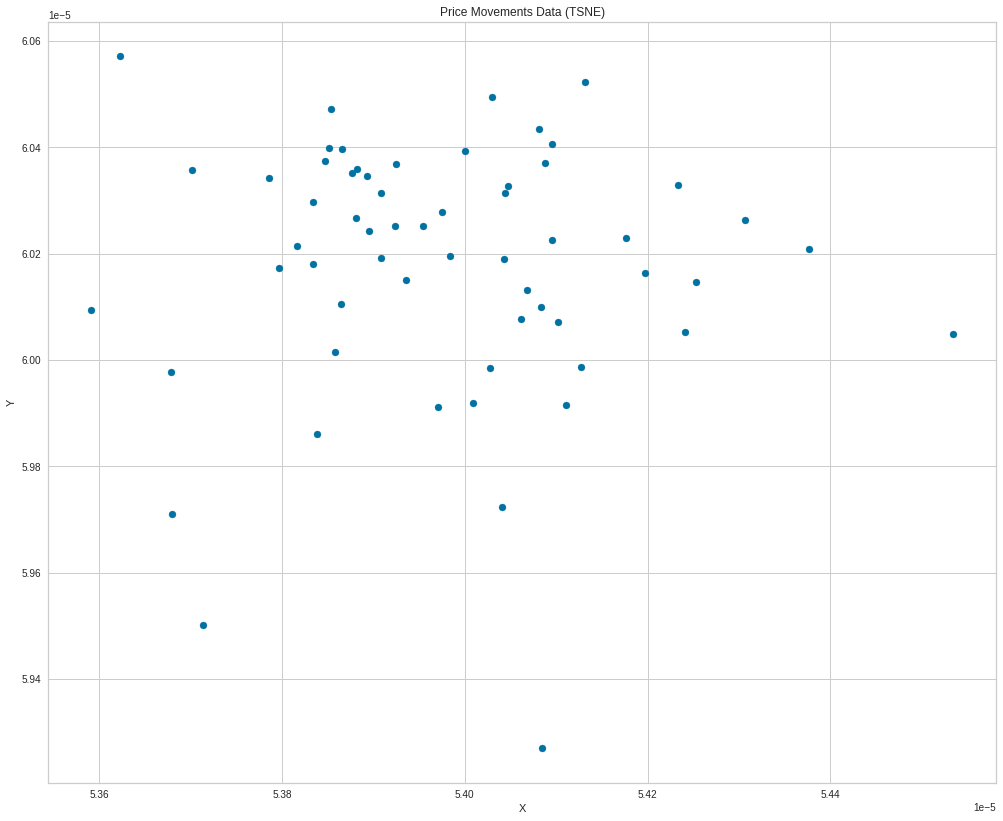

In [263]:
x_movements_tsne = movements_tsne[:, 0]
y_movements_tsne = movements_tsne[:, 1]

plt.scatter(x_movements_tsne, y_movements_tsne)
plt.title("Price Movements Data (TSNE)")
plt.xlabel("X")
plt.ylabel("Y");

### K-Means

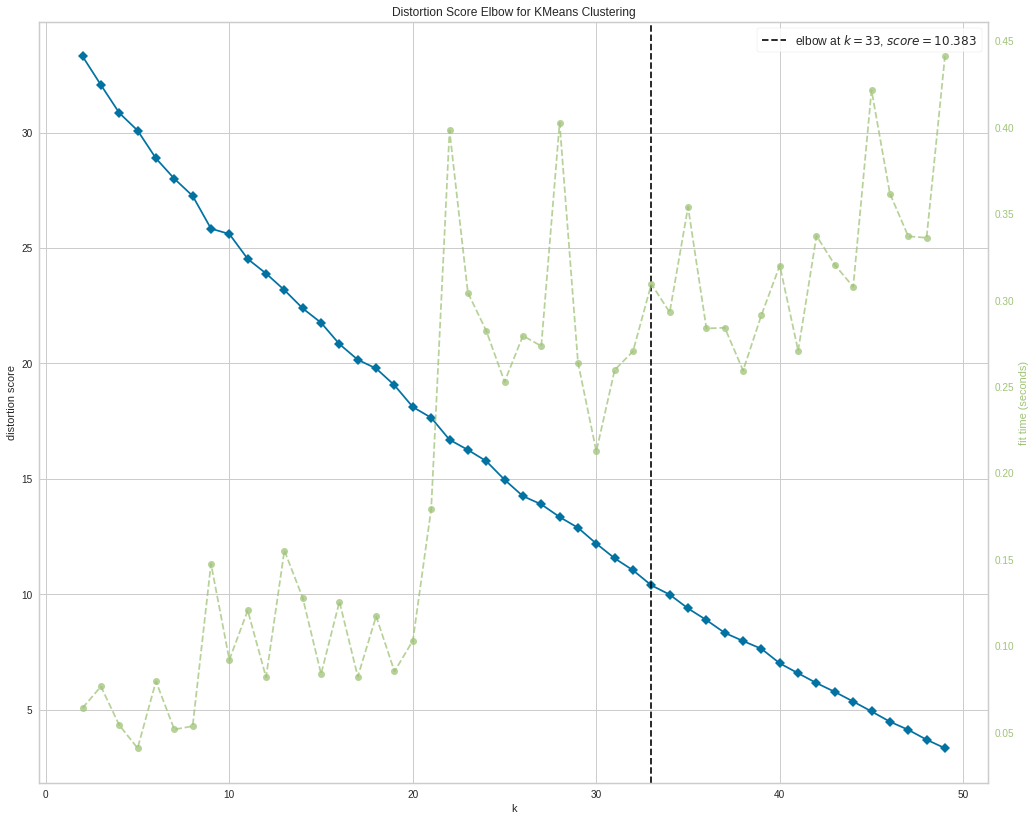

In [265]:
# Define range for number of clusters
k_range = range(2, 50)

model_movements_kmeans = sklearn_kmeans(n_init=10, random_state=rs)

visualizer = KElbowVisualizer(
    estimator=model_movements_kmeans, k=k_range, metric="distortion", timings=True
)
visualizer.fit(movements_normalized.to_numpy())
visualizer.show();

In [266]:
# Pipeline
pipeline_movements_kmeans = Pipeline(
    [
        ("normalizer", Normalizer()),
        (
            "kmeans",
            KMeans(n_clusters=33, random_state=12, n_init=10, output_type="numpy"),
        ),
    ]
)

# Fit the pipeline to samples and predict the cluster labels
movements_labels_kmeans = pipeline_movements_kmeans.fit_predict(movements)

movements_labels_kmeans

array([22, 25,  7,  3,  1,  3,  4,  2,  6, 13,  0, 31,  0,  6, 20, 32,  3,
        8,  3, 28, 30, 27, 11,  6, 15, 10,  3, 13,  9,  1, 17, 19,  6,  5,
       27, 24,  1,  4,  9, 23, 13, 18, 28, 28,  0, 27, 28, 29, 27, 28, 15,
       15,  4, 21, 16,  3, 12,  0, 26, 14], dtype=int32)

### DBSCAN & HDBSCAN

In [267]:
movements_dbscan = DBSCAN(eps=0.01, min_samples=2, metric="euclidean")
movements_dbscan.fit(movements_normalized)

(movements_dbscan.labels_ == -1).all()

True

In [185]:
movements_hdbscan = DBSCAN(min_samples=2, metric="euclidean")
movements_hdbscan.fit(movements_normalized)

(movements_hdbscan.labels_ == -1).all()

True

Interestingly, density-based clustering algorithms like DBSCAN and HDBSCAN labeled all data points as outliers. This is true for all settings:

* DBSCAN with small epsilon and smaller minimum sample, large epsilon with small minimum sample, small epsilon with large minimum sample, and large epsilon with large minimum sample

* HDBSCAN with similar settings returns the same results

What is more, if we set `min_samples=1`, then each data point would be its own cluster.

In [268]:
movements_dbscan = DBSCAN(eps=0.01, min_samples=1, metric="euclidean")
movements_dbscan.fit(movements_normalized)

len(cp.unique(movements_dbscan.labels_))

60

In [269]:
movements_hdbscan = DBSCAN(min_samples=1, metric="euclidean")
movements_hdbscan.fit(movements_normalized)

len(cp.unique(movements_hdbscan.labels_))

60

### Agglomerative Clustering

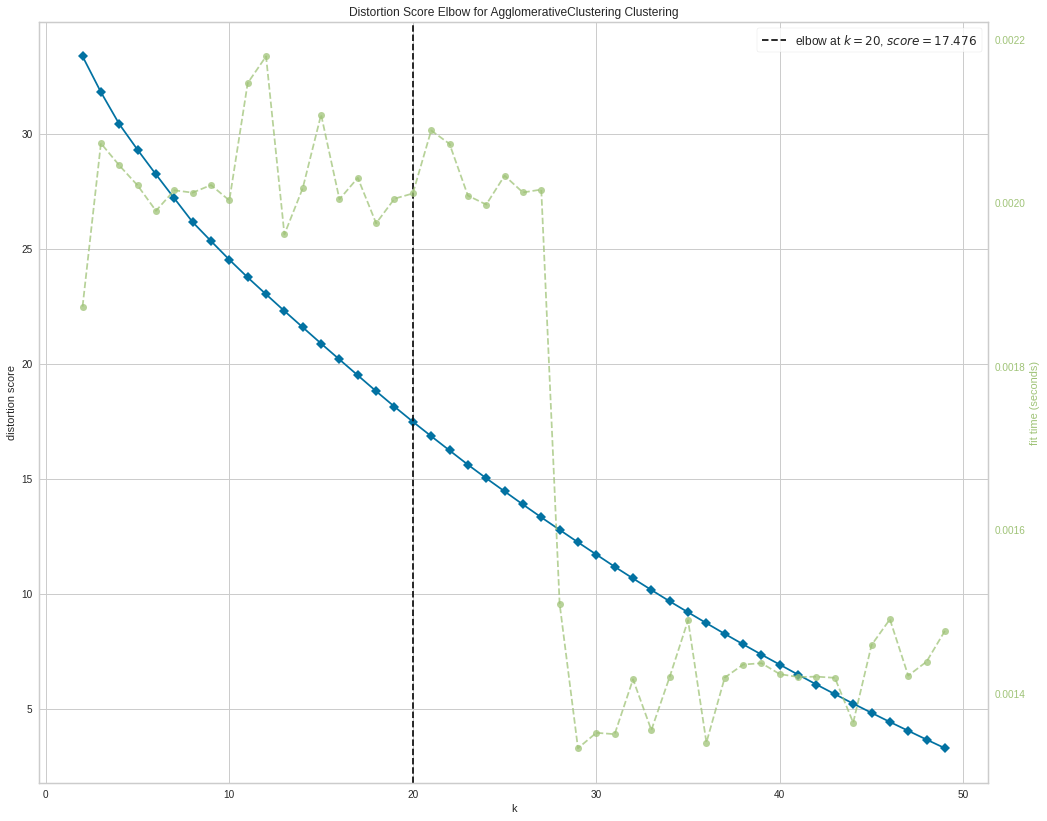

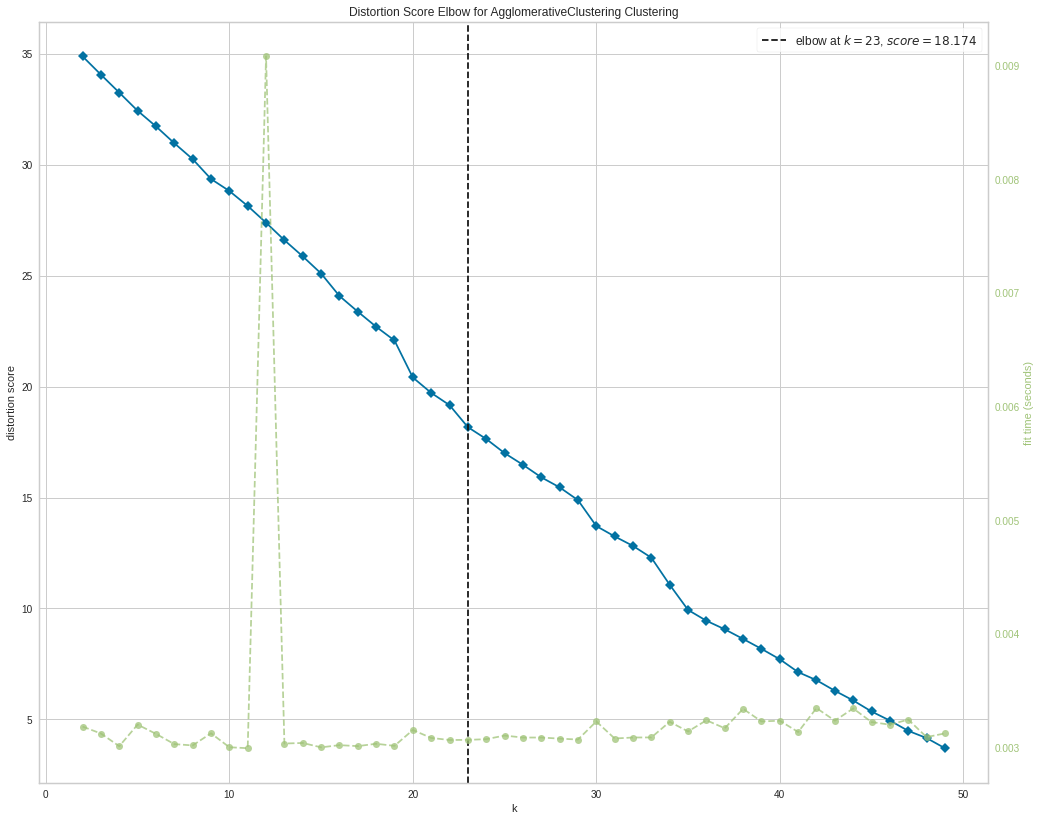

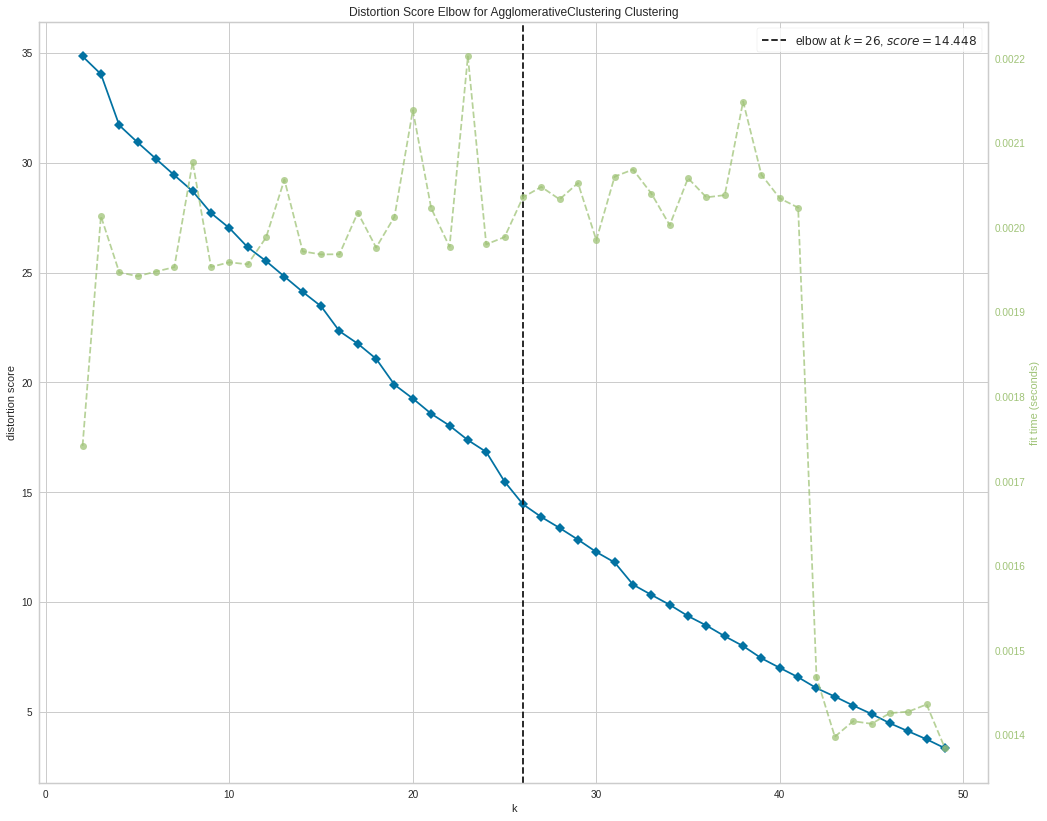

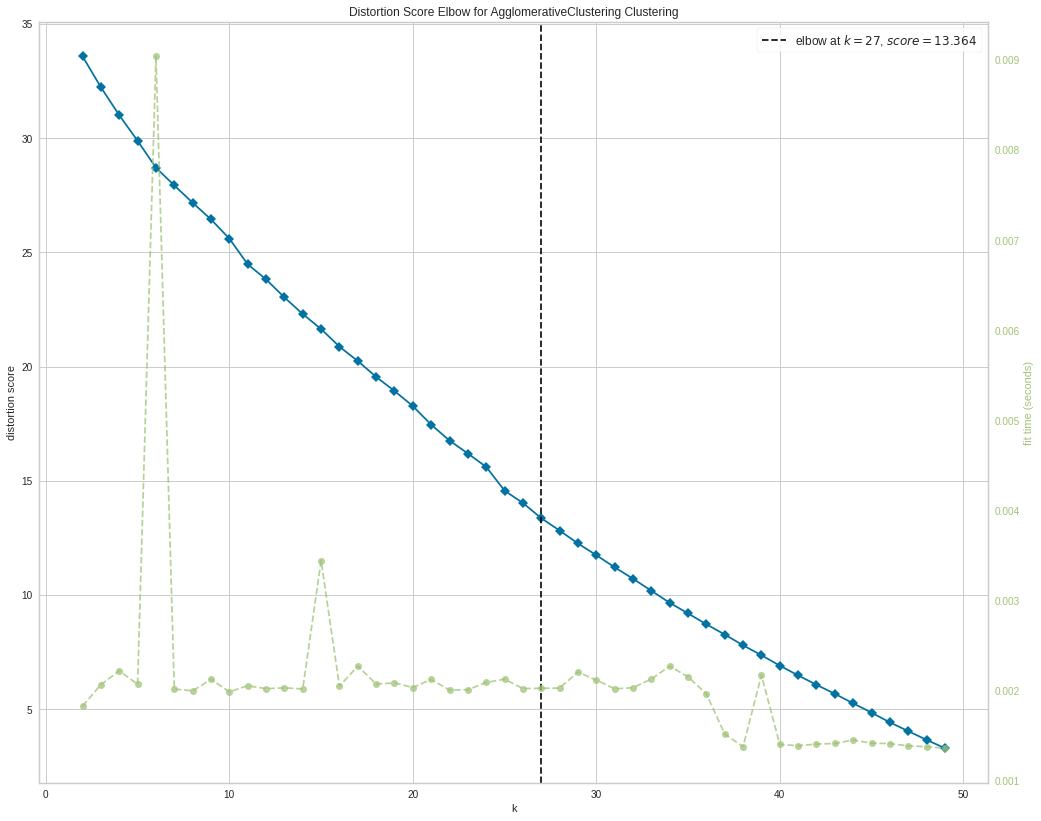

In [270]:
# Define range for number of clusters
k_range = range(2, 50)

for criterion in ["ward", "single", "average", "complete"]:
    model_movements_agg = sklearn_agg_cluster(linkage=criterion)

    visualizer = KElbowVisualizer(
        estimator=model_movements_agg, k=k_range, metric="distortion", timings=True
    )
    visualizer.fit(movements_normalized.to_numpy())
    visualizer.show()

Running the method shows the following suggested number of clusters:

* Ward: 20

* Single: 23

* Average: 26

* Complete: 27

Therefore, we will try a range of values for number of clusters between 20 and 27.

In [271]:
# Currently, the cuml package only supports single linkage criterion
pipeline_movements_agg = Pipeline(
    [
        ("normalizer", Normalizer()),
        (
            "agg_cluster",
            AgglomerativeClustering(
                n_clusters=27, linkage="single", output_type="numpy"
            ),
        ),
    ]
)

# Fit the pipeline to samples and predict the cluster labels
movements_labels_agg = pipeline_movements_agg.fit_predict(movements)

movements_labels_agg

array([26, 25, 24,  1,  1,  1,  1,  1,  1,  2,  1, 23,  1,  1, 22,  1,  1,
       21,  1,  1, 20,  1, 19, 18,  3, 17,  1,  2,  0,  1, 16, 15,  1, 14,
        1, 13,  1,  1,  0, 12,  2, 11,  1,  1,  1,  1,  1, 10,  1,  1,  9,
        3,  1,  8,  7,  1,  6,  1,  5,  4], dtype=int32)

### Comparing Results

We can inspect the results of the clustering outputs between K-means and Agglomerative clusterings in a table. We will not include the results of DBSCAN and HDBSCAN, since they either label all companies as outliers or assign them as their own clusters.

In [272]:
# Create a DataFrame aligning labels and companies
movements_cluster_results = cudf.DataFrame(
    {
        "companies": movements.index.values_host,
        "labels_agg_cluster": movements_labels_agg,
        "labels_kmeans": movements_labels_kmeans,
    }
)

In [275]:
# Sorting by agglomerative clustering
movements_cluster_results[["companies", "labels_agg_cluster"]].sort_values(
    ["labels_agg_cluster"]
)

,companies,labels_agg_cluster
28,Coca Cola,0
38,Pepsi,0
3,American express,1
4,Boeing,1
5,Bank of America,1
6,British American Tobacco,1
7,Canon,1
8,Caterpillar,1
10,ConocoPhillips,1
12,Chevron,1


In [276]:
# Sorting by k-means clustering
movements_cluster_results[["companies", "labels_kmeans"]].sort_values(["labels_kmeans"])

,companies,labels_kmeans
10,ConocoPhillips,0
12,Chevron,0
44,Schlumberger,0
57,Exxon,0
4,Boeing,1
29,Lookheed Martin,1
36,Northrop Grumman,1
7,Canon,2
3,American express,3
5,Bank of America,3


We can also visualize the results of agglomerative clustering using dendrograms:

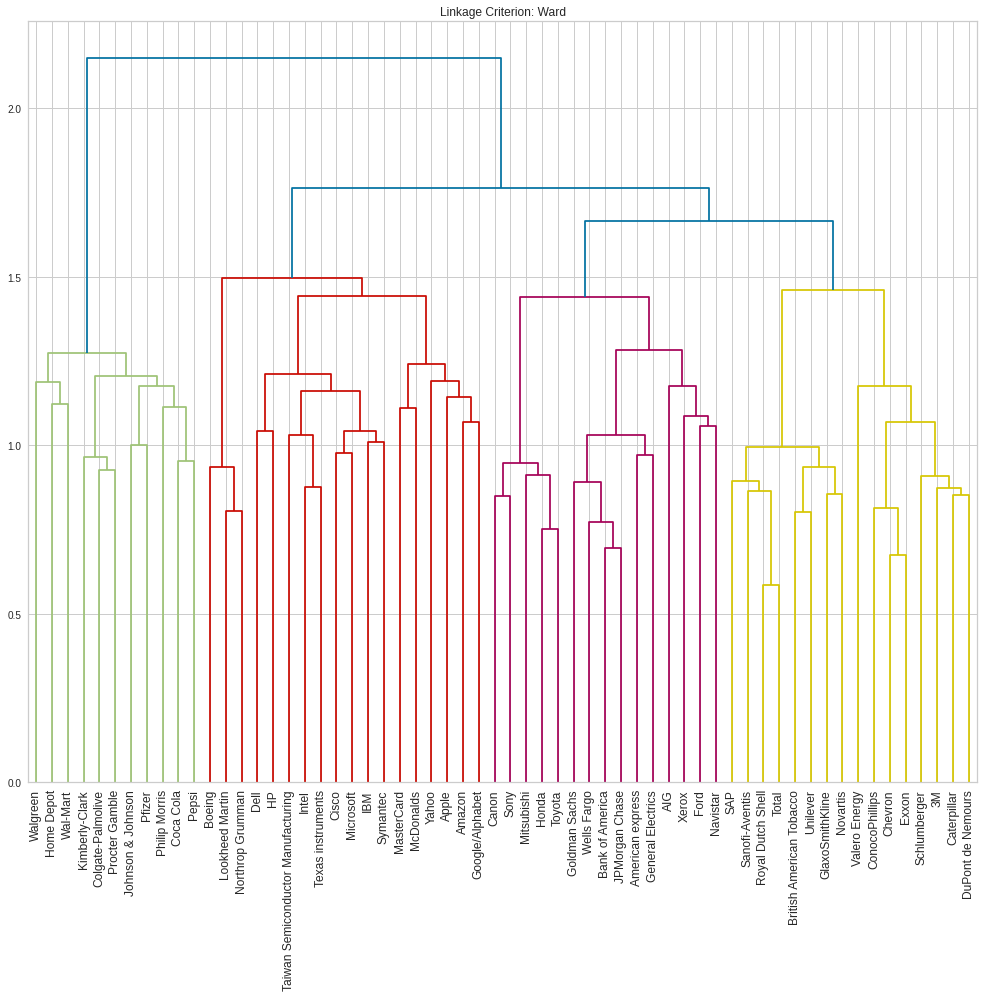

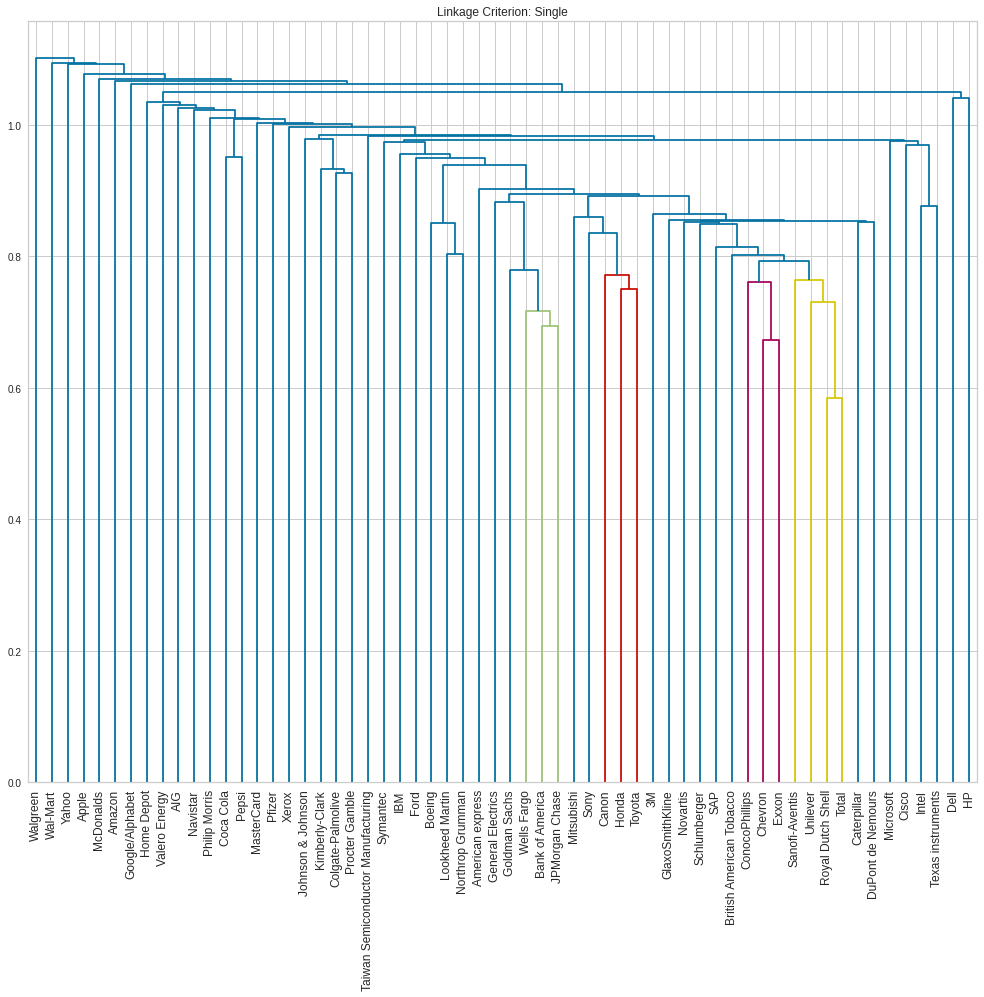

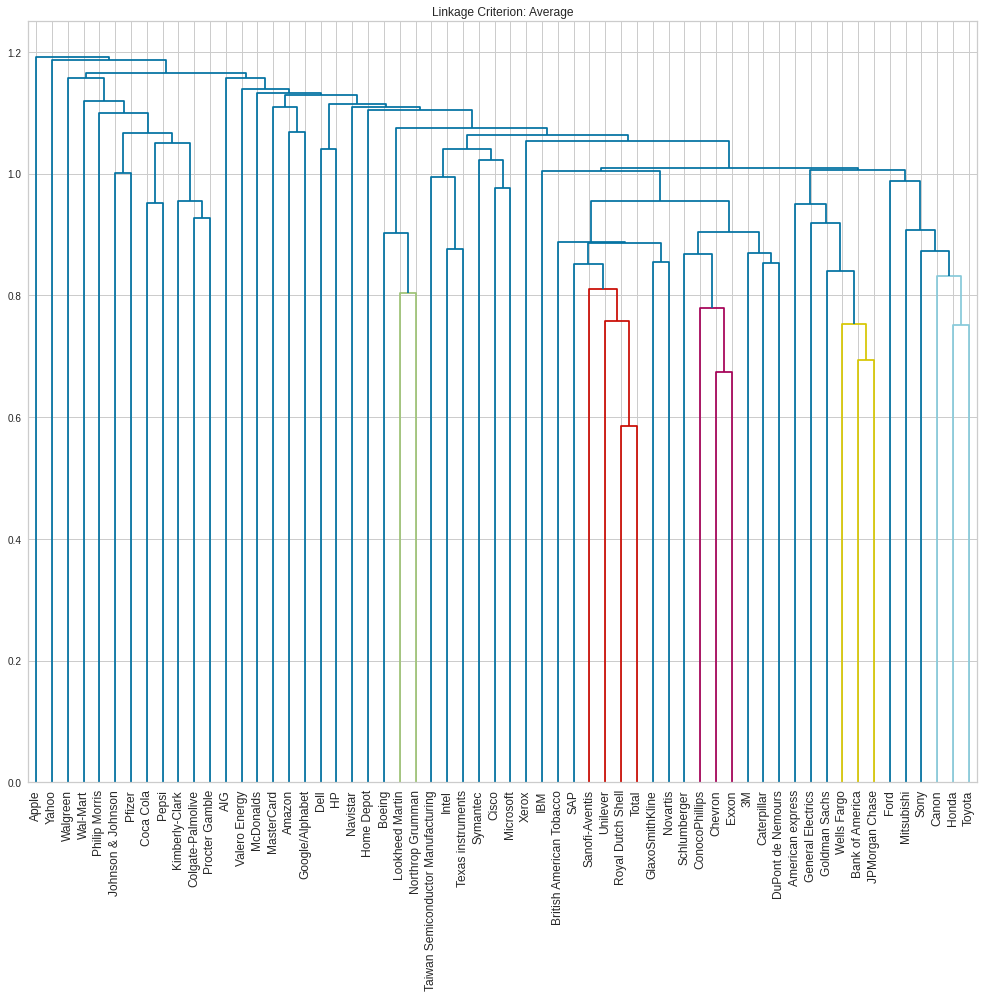

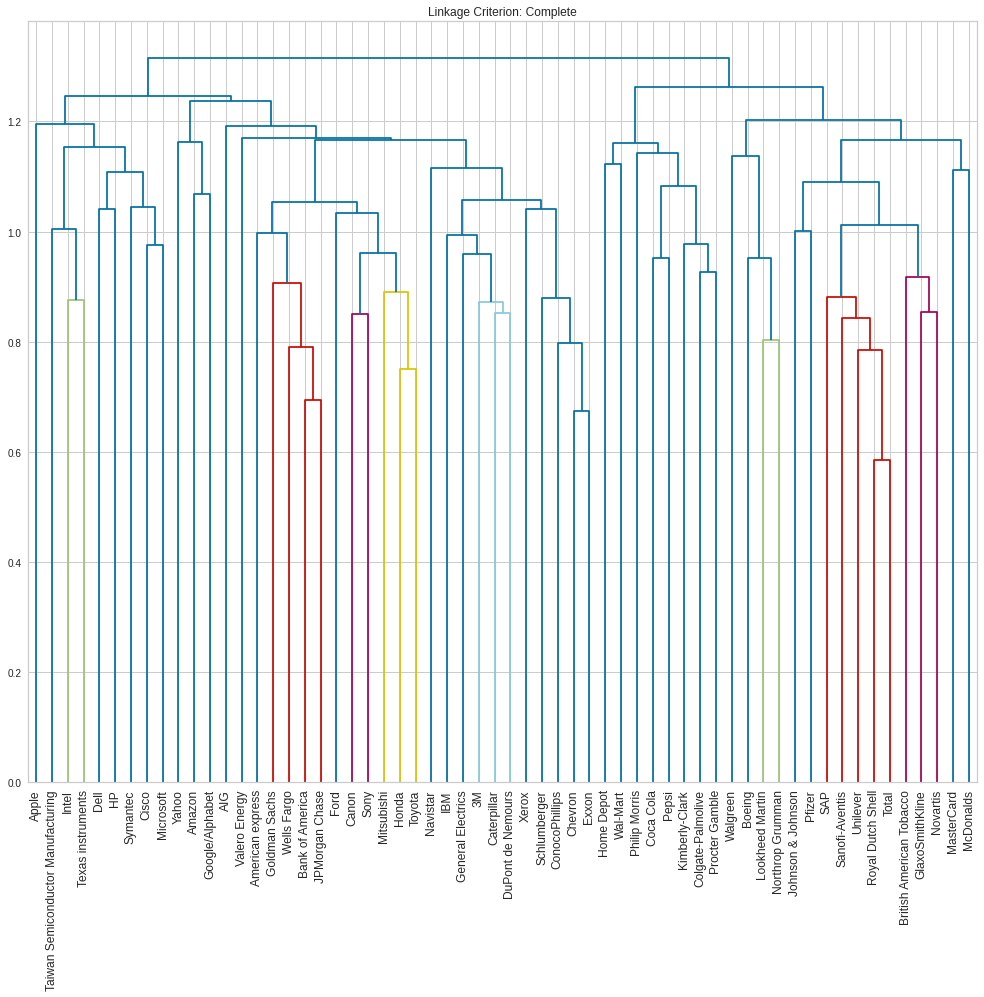

In [277]:
for criterion in ["ward", "single", "average", "complete"]:
    mergings = linkage(movements_normalized.to_numpy(), method=criterion)
    dendrogram(
        mergings,
        labels=movements.index.values_host,
        leaf_rotation=90.0,
        leaf_font_size=12,
    )
    plt.title("Linkage Criterion: " + criterion.capitalize())
    plt.show()

### Observations

For a data matrix that is as high-dimensional as the price movements dataset, the three clustering techniques produced different results:

* K-means prodced the most number of clusters

* Density-based clustering algorithms such as DBSCAN and HDBSCAN either clustered the high-dimensional vectors into their own clusters or all as outliers. 

* Agglomerative clustering results were more comparable to that of K-means

Based on these results, the agglomerative clustering technique appears to be the most suitable this use case--- high dimensional data (wide data matrix). What is important is that the dendrogram makes the results of the agglomerative clustering more interpretable. This is further aided by the fact that the movements data has some sense of a ground truth in the form of the company names, allowing us to inspect the outputs of clustering.